In [1]:
import sys
import time
import numpy as np
import numba
from numba import prange
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import multiprocessing

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

sys.path.append('../lib/')
sys.path.append('../lib_attic/')
from utils import *
from graph import *
from preprocessing import *
import gmr
import gmr_   # nn improvements with numba + sorted elements
#import gmr_v0 # original with python structs
#import gmr_v1 # nn improvements with python structs
#import gmr_v2 # nn improvements with numba

from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning

def load_data(fits_path):
    hdu = fits.open(fits_path)[0]
    data = hdu.data
    wcs = WCS(hdu.header)

    if data.ndim>3:
        # droping out the stokes dimension
        data = np.ascontiguousarray(data[0])
        wcs = wcs.dropaxis(3)

        if data.shape[0]==1:
            # in case data is not a cube but an image
            data = np.ascontiguousarray(data[0])
            wcs = wcs.dropaxis(2)
    
    # in case NaN values exist on data
    mask = np.isnan(data)
    if np.any(mask): data = ma.masked_array(data, mask=mask)

    return data,wcs,hdu

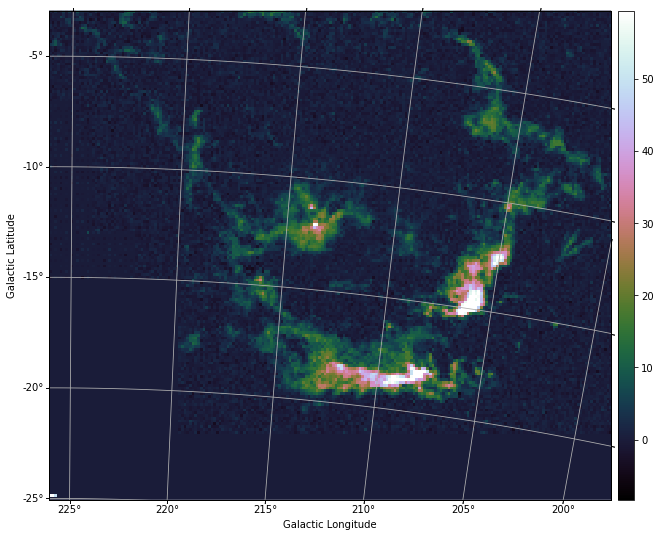

In [2]:
#fits_path = '../data/images/Orion.cont.image.fits'
fits_path = '../data/SCIMES/orion_12CO_mom0.fits'

data, wcs, hdu = load_data(fits_path)
image_plot(data, wcs=wcs)

In [3]:
# mask of significant emission pixels
#mask = compute_mask(data, 0.089)
#mask = compute_mask(data, 1.00798)

data = np.copy(data)
#back_level = 0.089
back_level = 1.00798
mask = compute_mask(data, back_level)
data[mask] -= back_level
data[~mask] = 0
vmin = data[mask].min(); vmax = data[mask].max()
data[mask] -= vmin
data[mask] /= vmax-vmin
del mask; mask = data>0 # removing the pixel with 0 value

# initial w
w = (data[mask]).astype(np.float64)

# pixels positions
_x = np.linspace(0., 1., data.shape[0]+1, endpoint=True)
_y = np.linspace(0., 1., data.shape[1]+1, endpoint=True)
xpos = np.asarray( [(_x[i]+_x[i+1])/2 for i in range(len(_x)-1)] )
ypos = np.asarray( [(_y[i]+_y[i+1])/2 for i in range(len(_y)-1)] )
X,Y  = np.meshgrid(xpos, ypos, indexing='ij')
xgrid = X.ravel()
ygrid = Y.ravel()
xc = X[mask]
yc = Y[mask]
mu = np.vstack([xc,yc]).T

# sigma
pix_lenght = min(1./data.shape[0], 1./data.shape[1])
k = 0.25
sig = (pix_lenght/(2.*k))*np.ones(w.shape[0])

***
***

__Note:__ Old versions take a lot of time... If you run the cells below go outside or take a nap. 

In [ ]:
%%prun -s tottime -q -l 30 -T gmr_v0_prof
gmr_v0.mixture_reduction(w, mu, sig, 200, verbose=False)

In [ ]:
print(open('gmr_v0_prof', 'r').read())

***

In [ ]:
%%prun -s tottime -q -l 30 -T gmr_v1_prof
gmr_v1.mixture_reduction(w, mu, sig, 200, verbose=False)

In [ ]:
print(open('gmr_v1_prof', 'r').read())

***

In [ ]:
%%prun -s tottime -q -l 30 -T gmr_v2_prof
gmr_v2.mixture_reduction(w, mu, sig, 200, verbose=False)

In [ ]:
print(open('gmr_v2_prof', 'r').read())

***
__Note:__ These two are the fastest versions of GMR until now:

In [5]:
%%prun -s tottime -q -l 30 -T gmr_prof
gmr.mixture_reduction(w, mu, sig, 200, verbose=False)

(6621, 42)
 
*** Profile printout saved to text file 'gmr_prof'. 


In [6]:
print(open('gmr_prof', 'r').read())

         1283581 function calls (1283573 primitive calls) in 10.617 seconds

   Ordered by: internal time
   List reduced from 245 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1095    2.873    0.003    2.873    0.003 {method 'acquire' of '_thread.lock' objects}
     6421    2.672    0.000    2.672    0.000 gmr.py:283(update_structs)
     6421    0.795    0.000    0.795    0.000 gmr.py:231(less_dissimilar)
     6422    0.627    0.000    0.992    0.000 {method 'query_radius' of 'sklearn.neighbors.ball_tree.BinaryTree' objects}
        1    0.510    0.510   10.617   10.617 gmr.py:318(mixture_reduction)
     6421    0.273    0.000    5.157    0.001 gmr.py:266(radius_search)
    12842    0.255    0.000    0.376    0.000 function_base.py:4703(delete)
   102951    0.179    0.000    0.179    0.000 {built-in method numpy.core.multiarray.array}
    12873    0.147    0.000    0.805    0.000 validation.py:310(check_array)
    12874    

***

In [22]:
%%prun -s tottime -q -l 30 -T gmr_prof_
gmr_.mixture_reduction(w, mu, sig, 200, verbose=False)

 
*** Profile printout saved to text file 'gmr_prof_'. 


In [23]:
print(open('gmr_prof_', 'r').read())

         3964981 function calls (3795681 primitive calls) in 51.455 seconds

   Ordered by: internal time
   List reduced from 2191 to 30 due to restriction <30>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     6400   39.727    0.006   39.727    0.006 gmr_.py:276(update_structs)
     7525    2.634    0.000    2.641    0.000 ffi.py:105(__call__)
        1    2.200    2.200   51.466   51.466 gmr_.py:346(mixture_reduction)
        1    0.933    0.933    0.933    0.933 gmr_.py:244(compute_dissimilarity)
      2/1    0.608    0.304    1.068    1.068 gmr_.py:229(_compute_neighbors)
     6401    0.588    0.000    0.891    0.000 {method 'query_radius' of 'sklearn.neighbors.ball_tree.BinaryTree' objects}
    76822    0.370    0.000    0.370    0.000 {built-in method numpy.core.multiarray.array}
    12803    0.137    0.000    0.720    0.000 validation.py:310(check_array)
     6400    0.134    0.000    1.705    0.000 gmr_.py:267(radius_search)
    12804    0.129    0.

***

In [2]:
%load_ext Cython

In [16]:
%%cython -a --cplus
#!python
#cython: cdivision=True, boundscheck=False, nonecheck=False, wraparound=False, initializedcheck=False


import numpy as np
#cimport numpy as cnp

from libc.math cimport sqrt
from libcpp.list cimport list 
from cython.operator import dereference, preincrement


cdef f(int x):
    cdef:
        list[int] arr
        list[int].iterator it
        arr.push_back(x)
        


Error compiling Cython file:
------------------------------------------------------------
...

cdef f(int x):
    cdef:
        list[int] arr
        list[int].iterator it
        arr.push_back(x)
       ^
------------------------------------------------------------

/Users/martin/.ipython/cython/_cython_magic_a5515c530525b33c5ebbe98d18e0df93.pyx:17:8: 'arr' is not a cimported module

Error compiling Cython file:
------------------------------------------------------------
...

cdef f(int x):
    cdef:
        list[int] arr
        list[int].iterator it
        arr.push_back(x)
                    ^
------------------------------------------------------------

/Users/martin/.ipython/cython/_cython_magic_a5515c530525b33c5ebbe98d18e0df93.pyx:17:21: Missing name in declaration.


TypeError: object of type 'NoneType' has no len()

***

## Current GMR approaches:

Let $N$ be the number of Gaussian components in the mixture $u$, and $k$ the (mean/maximum) number of neighbors of a single Gaussian  component. 

#### First approach:

Using a dissimilarity matrix (`diss_matrix`) which stores the dissimilarity (`KLdiv`) between the components. In `nn_indexes` is stored the neighbors for each of the _alive_ components in the mixture.  

1. Compute neighbors (`nn_indexes`): $O(N^2)$.
2. Compute the dissimilarity matrix (`diss_matrix`): $K_{N \times k}$: $O(Nk)$.
3. Inside the main loop:
    1. Find the least dissimilar components: $O(Nk)$.
    2. Update indexes of _alive_ components: $O(N)$.
    3. Radius search for the new component: $O(\log(N))$.
    4. Update structs (`nn_indexes` and `diss_matrix`): $O(Nk)$ + $O(k)$. 
    
    
#### Second approach

Using a list with the pair of components $(i,j)$ ordered by its `KLdiv`.

1. Compute neighbors (`nn_indexes`): $O(N^2)$.
2. Compute the dissimilarities (`diss_array`): $K_{N \times k}$: $O(Nk)$.
3. Inside the main loop:
    1. Find the least dissimilar components: $O(1)$.
    2. Radius search for the new component: $O(\log(N))$.
    3. Update structs (`nn_indexes` and `diss_array`): $O(k)$ + $O(Nk)$. 

(currently tested with numpy arrays and python lists).

***